# Includes

In [ ]:
# data frame and computation
import pandas as pd
import numpy as np
import scipy.stats as stats
import re

# file manipulation
import yaml
import os

# data manipulation
from urllib.parse import urlparse

# ip lookups
import requests

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
import seaborn as sns
import joypy
import folium

# SQL
import pyodbc 
import sqlalchemy as sa
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

# timing
import time

# Variables

In [ ]:
server = None
port = None
warehouse = None
shard0 = None
shard1 = None
items = None
username = None
password = None

target = 'dev'
profile = 'sitecore_warehouse'

start_path = os.path.expanduser("~\\.dbt\\")
with open(f"{start_path}profiles.yml", "r", encoding="utf-8") as f: 
    config = yaml.safe_load(f) 
    server = config[profile]["outputs"][target]["server"]
    port = config[profile]["outputs"][target]["port"]
    warehouse = config[profile]["outputs"][target]["database"]
    shard0 = config[profile]["outputs"][target]["database_shard0"]
    shard1 = config[profile]["outputs"][target]["database_shard1"]
    items = config[profile]["outputs"][target]["database_items"]
    username = config[profile]["outputs"][target]["user"]
    password = config[profile]["outputs"][target]["password"]

## Colors

In [3]:
plot_palette = [
    'cornflowerblue', 
    'mediumslateblue', 
    'darkorchid', 
    'darkmagenta', 
    'mediumvioletred', 
    'deeppink', 
    'orangered', 
    'orange', 
    'gold', 
    'yellow', 
    'greenyellow', 
    'lime'
]

plot_palette_hex = [
    '#6495ed', 
    '#7b68ee',
    '#9932cc', 
    '#8b008b', 
    '#c71585', 
    '#ff1493', 
    '#ff4500', 
    '#ffa500', 
    '#ffd700', 
    '#ffff00', 
    '#adff2f', 
    '#00ff00'
]

plot_palette_hex_extended = [
    '#3e62a3',
    '#6495ed',
    '#5a4da8',
    '#7b68ee',
    '#641e87',
    '#9932cc',
    '#8b008b',
    '#e605e6',
    '#800f56',
    '#c71585',
    '#a80a60',
    '#ff1493',
    '#b83404',
    '#ff4500',
    '#bd7b02',
    '#ffa500',
    '#b59902',
    '#ffd700',
    '#bfbf02',
    '#ffff00',
    '#7cb524',
    '#adff2f',
    '#02b002',
    '#00ff00'
]

grid_gray = '#dddddd'

cornflowerblue


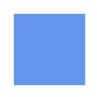

mediumslateblue


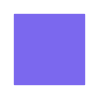

darkorchid


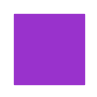

darkmagenta


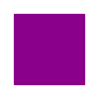

mediumvioletred


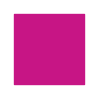

deeppink


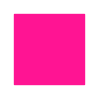

orangered


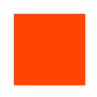

orange


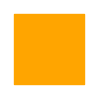

gold


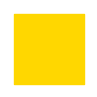

yellow


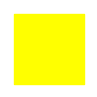

greenyellow


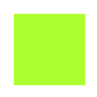

lime


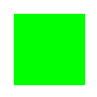

#6495ed


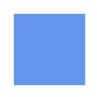

#7b68ee


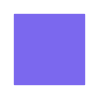

#9932cc


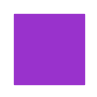

#8b008b


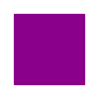

#c71585


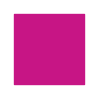

#ff1493


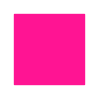

#ff4500


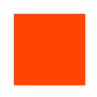

#ffa500


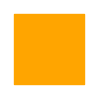

#ffd700


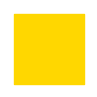

#ffff00


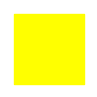

#adff2f


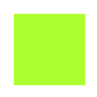

#00ff00


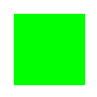

In [4]:
for p in plot_palette:
    fig, ax = plt.subplots(figsize=(1, 1))
    print(p)
    ax.fill_between([0, 1], 0, 1, color=p) 
    ax.axis('off')
    plt.show()

for p in plot_palette_hex:
    fig, ax = plt.subplots(figsize=(1, 1))
    print(p)
    ax.fill_between([0, 1], 0, 1, color=p) 
    ax.axis('off')
    plt.show()


# Functions

## Utils

In [5]:
def rename_event_columns(data):
    data.rename(columns={
    'EventType_ChangeProfileScoresEvent':'ChangeProfileScoresEvent',
    'EventType_CampaignEvent':'CampaignEvent',	
    'EventType_DownloadEvent':'DownloadEvent',
    'EventType_Error':'Error',
    'EventType_Event':'Event',
    'EventType_Goal':'Goal',
    'EventType_MVTestTriggered':'MVTestTriggered',
    'EventType_Outcome':'Outcome',
    'EventType_PageViewEvent':'PageViewEvent',
    'EventType_PersonalizationEvent':'PersonalizationEvent',
    'EventType_SearchEvent':'SearchEvent'}, inplace=True)

In [6]:
def format_func(x, p):
    return f"{int(x):,}"

In [7]:
def get_percent_change(col_1, col_2):
    percent_1 = (col_1 / col_1.sum()) * 100
    percent_2 = (col_2 / col_2.sum()) * 100
    percent_ratio = round(percent_1 / percent_2, 1)

    return percent_ratio

In [603]:
def set_and_trim_dates(data):
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data['TimestampSortDate'] = data['Timestamp'].dt.strftime('%Y-%m')

    return data

In [ ]:
def print_corr_stats(data, field1, field2, title):
    v1_int = [int(x) for x in data[field1]]
    v2_int = [int(x) for x in data[field2]]
    if(v1_int == [] or v2_int == []):
        print('There are no values')
        print()
        return
    
    correlation, p_value = stats.pearsonr(v1_int, v2_int)
    print(title)
    print(f"Pearson Correlation: {correlation:.2f} for {field1} and {field2}")
    print(f"P-Value: {p_value}")
    print(f"Is Valid: {p_value < 0.05}")
    print('')

## Plot Hist

In [9]:
def plot_horiz_hist(data, field, title=None, x_label=None, single_color=False, size=None):
    
    # filter out nulls
    sub_df = data[~data[field].isna()]

    # if numeric then round to int for display
    if((pd.api.types.is_numeric_dtype(sub_df[field].dtype)) & (sub_df[field].dtype != bool)):
        sub_df[field] = sub_df[field].astype(int)

    # get and sort value counts
    value_counts = sub_df[field].astype('category').value_counts()
    sorted_df = pd.DataFrame({
        field: value_counts.index,
        'count': value_counts.values
    })

    # get required colors
    palette = plot_palette[:len(sorted_df)]
    palette.reverse()
    
    size = size if size else (12, 6)
    plt.figure(figsize=size)
    plt.gcf().patch.set_alpha(0)
    
    if single_color:
        bp = sns.barplot(
            data=sorted_df,
            y=field,
            x='count',
            color=plot_palette_hex[4],
            order=sorted_df[field],
            legend=False
        )
        bp.patch.set_alpha(0)
    else:
        bp = sns.barplot(
            data=sorted_df,
            y=field,
            x='count',
            palette=palette,
            order=sorted_df[field],
            hue='count',
            legend=False
        )
        bp.patch.set_alpha(0)
        
    plt.grid(True, axis='x', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='x', length=0)
        
    # remove spines
    spines = ['top', 'right', 'bottom']
    for s in spines:
        plt.gca().spines[s].set_visible(False)
    
    # set and format labels
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    plt.title(title if title else f'{field} Distribution')
    plt.xlabel(x_label if x_label else '')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_hist(data, field, sorted=False, title=None, size=None):
    
    # get and sort value counts
    value_counts = data[field].astype('category').value_counts()
    sorted_df = pd.DataFrame({
        field: value_counts.index,
        'count': value_counts.values
    })
    
    # set sort order
    sort_order = sorted_df[field] if sorted else None
    
    size = size if size else (10, 6)
    plt.figure(figsize=size)   
    plt.gcf().patch.set_alpha(0)
    
    bp = sns.barplot(
        data=sorted_df,
        x=field,
        y='count',
        color=plot_palette[:1][0],
        order=sort_order,
        legend=False
    )
    bp.patch.set_alpha(0)
    
    # remove spines
    spines = ['top', 'right', 'left']
    for s in spines:
        plt.gca().spines[s].set_visible(False)

    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)
    
    # format numeric values with commas
    # if numeric then round to int for display
    if((pd.api.types.is_numeric_dtype(data[field].dtype)) & (data[field].dtype != bool)):
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))   
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    # set and format labels
    title = title if title else f'{field} Distribution'
    plt.title(title)
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [11]:
def plot_hist_numeric(data, field, title=None, size=None, x_label=None, y_label=None):
    
    size = size if size else (10, 6)
    plt.figure(figsize=size)   
    plt.gcf().patch.set_alpha(0)
    
    hp = sns.histplot(data[field], bins=10, color=plot_palette_hex[4])
    hp.patch.set_alpha(0)
    
    # remove spines
    spines = ['top', 'right', 'left']
    for s in spines:
        plt.gca().spines[s].set_visible(False)

    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)
    
    # format numeric values with commas
    # if numeric then round to int for display
    if((pd.api.types.is_numeric_dtype(data[field].dtype)) & (data[field].dtype != bool)):
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))   
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    # set and format labels
    title = title if title else f'{field} Distribution'
    plt.title(title)
    xlabel = x_label if x_label else ''
    plt.xlabel(xlabel)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    ylabel = y_label if y_label else ''
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_hist_grid(data, values, rows, cols, size=None):
    
    fsize = size if size else (15, 7)
    fig=plt.figure(figsize=fsize)
    fig.patch.set_alpha(0)

    pos = 1
    for v in values:
        ax=fig.add_subplot(rows,cols,pos)
        hp = data[v].hist(edgecolor='none', rwidth=0.75, ax=ax, color=plot_palette[4:5][0])
        hp.patch.set_alpha(0)
        hp.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))   

        plt.grid(visible=True, axis='y', color=grid_gray)
        plt.grid(visible=False, axis='x')
        hp.set_axisbelow(True)
        hp.tick_params(axis='y', length=0)

        # remove spines
        spines = ['top', 'right', 'left']
        for s in spines:
            ax.spines[s].set_visible(False)
        ax.set_title(v)
        ax.xaxis.set_tick_params(rotation=45)
        pos += 1
        
    fig.tight_layout()
    plt.show()

## Plot Bars

In [13]:
def plot_bar(data, id_var, value_vars, title=None, x_label=None, rotate_labels=True):
    melted_df = data.melt(id_vars=id_var, 
                                    value_vars=value_vars, 
                                    var_name='Metric', 
                                    value_name='Value')

    # Create the barplot
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    fig.patch.set_alpha(0)

    sns.barplot(data=melted_df, x=id_var, y='Value', hue='Metric', palette=plot_palette[3:], ax=ax)
    ax.patch.set_alpha(0)

    # legend
    plt.gca().legend(loc='upper left', bbox_to_anchor=(1.15, 1), edgecolor='black', shadow=False, fancybox=False)

    # axis labels and formatting
    ax.set_ylabel('')
    ax.set_title(title if title else '')
    ax.set_xlabel(x_label if x_label else '')
    spines = ['right', 'left', 'top']
    for s in spines:
        ax.spines[s].set_visible(False)

    if rotate_labels:
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor') 

    # plot
    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

In [604]:
def plot_bar_stack(data, group_field, category_field, title=None, show_legend=True, line_overlay=None, plot_size=None, colors=None, x_label=None, y_label=None):
    
    group_sizes = data.groupby(group_field).size().sort_values(ascending=False)
    group_sizes.index = group_sizes.index.astype(str)
    sorted_groups = group_sizes.index.tolist()

    counts = pd.crosstab([data[category_field]], [data[group_field].astype('string')])[sorted_groups]
    melted = counts.reset_index().melt(id_vars=category_field, var_name=group_field, value_name='Count')
    
    p_size = plot_size if plot_size else (10, 6)
    plt.figure(figsize=p_size)
    plt.gcf().patch.set_alpha(0)

    plot_colors = colors if colors else plot_palette[:len(sorted_groups)]

    ax = sns.barplot(
        data=melted,
        x=category_field,
        y='Count',
        hue=group_field,
        palette=plot_colors,
        legend=show_legend,
        dodge=False
    )
    ax.patch.set_alpha(0)

    if line_overlay:
        for line in line_overlay:
            line_data = line['Data'] if 'Data' in line else data
            lp = sns.lineplot(data=line_data, x=category_field, y=line['Field'], color=line['Color'], label=line['Label'], errorbar=None, estimator=line['estimator'], linewidth=2)
            lp.set_alpha(0)

    bottoms = {}
    for bars in ax.containers:
        for bar in bars:
            x, y = bar.get_xy()
            h = bar.get_height()
            if x in bottoms:
                bar.set_y(bottoms[x])
                bottoms[x] += h
            else:
                bottoms[x] = h
    ax.relim()  # the plot limits need to be updated with the moved bars
    ax.autoscale()

    if show_legend:
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            title=group_field,
            edgecolor='black',
            shadow=False,
            fancybox=False
        )    
    
    spines = ['top', 'right', 'left']
    for s in spines:
        ax.spines[s].set_visible(False)

    ticks = ax.get_xticks()
    labels = ax.get_xticklabels()
    if(len(ticks) > 7):
        ax.set_xticks(ticks[3::4])
        ax.set_xticklabels(labels[3::4]) 
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    
    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)
    title = title if title else f'{category_field} by {group_field}'
    plt.title(title)
    plt.xlabel(x_label if x_label else '')
    plt.ylabel(y_label if y_label else '')
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.tight_layout()
    plt.show()

## Plot Scatter

In [15]:
def plot_scatter(data, x_field, y_field, size_field, color_field, title=None, show_legend=True, plot_size=None, colors=None, alpha=None, x_label=None, y_label=None):
    
    p_size = plot_size if plot_size else (10, 6)
    plt.figure(figsize=p_size)
    plt.gcf().patch.set_alpha(0)

    alpha_value = alpha if alpha else 0.2

    ax = sns.scatterplot(
        data=data,
        x=x_field,
        y=y_field,
        size=size_field,
        hue=color_field,
        edgecolor='black',
        linewidth=1,
        palette='viridis',
        alpha=alpha_value,
        sizes=(0, 450),  # Adjust the range of sizes if needed
        legend=True
    )
    ax.patch.set_alpha(0)

    if show_legend:
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            edgecolor='black',
            shadow=False,
            fancybox=False
        )    
    
    spines = ['top', 'right', 'left']
    for s in spines:
        ax.spines[s].set_visible(False)

    xlabel = x_label if x_label else x_field
    ylabel = y_label if y_label else y_field

    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)
    title = title if title else f'{x_field} by {y_field}'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

## Plot Pies

In [16]:
def plot_pie(data, field, title=None):

    fig, ax = plt.subplots()
    fig.patch.set_alpha(0)
    
    os_data = data.groupby(field)[field].count().sort_values(ascending=False)

    patches, texts = plt.pie(os_data.values, colors=plot_palette[:len(os_data)], startangle=90, wedgeprops=dict(width=0.5))
    
    percent = 100.*os_data.values/os_data.values.sum()
    labels = ['{0} - {1:1.2f}%'.format(i,j) for i,j in zip(os_data.index, percent)]
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, os_data.values), key=lambda x: x[2], reverse=True))

    plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, edgecolor='black', shadow=False, fancybox=False)
    plt.title(title if title else field)
    plt.tight_layout()
    plt.show()

## Plot Goals

In [17]:
# this is a measure of the change from the percentage of goal pages each page type has to the percent of traffic it gets. 
# so if Blog Post Page makes up 18% of your goal pages but only gets 11% of the traffic 
    # then it roughly has a score of 2:1 which is 0.5 (the yellow line) indicating a lower share than expected. 
    # above 1 is a higher share. 
    # this indicates which page types are more or less effective at getting goals
    # for example more blog post pages may not result in more goals but 
    # more Project Pages may which doesn't have many pages but gets a larger share of goals

def plot_goal_ratios(data, data_labels):
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0)
    fig.set_size_inches(12, 6)

    result_df = data.groupby('TemplateName')\
        .agg(
            EventCount=('InteractionEventId','count'),
            ItemCount=('ItemId',lambda x: x.nunique(dropna=True))
        ).reset_index()

    # find percentages for each column
    result_df['EventPercent'] = (result_df['EventCount'] / result_df['EventCount'].sum()) * 100
    result_df['ItemPercent'] = (result_df['ItemCount'] / result_df['ItemCount'].sum()) * 100

    # calculate the ratio
    result_df['Ratio'] = round(result_df['EventPercent'] / result_df['ItemPercent'], 1)

    # transform data
    melted_df = result_df.melt(id_vars='TemplateName', value_vars=['EventPercent', 'ItemPercent'], 
                        var_name='Type', value_name='Percent')
    melted_df = melted_df.join(result_df[['TemplateName','Ratio']].set_index('TemplateName'), on='TemplateName')

    # plots
    lp = sns.lineplot(data=result_df.sort_values('Ratio', ascending=False), x="TemplateName", y="Ratio", color=plot_palette_hex[7], ax=ax, label='Ratio', legend=False, errorbar=None, linewidth=2, zorder=2)
    lp.patch.set_alpha(0)

    # create a second axis
    ax2 = ax.twinx()  

    bp = sns.barplot(data=melted_df.sort_values('Ratio', ascending=False), x='TemplateName', y='Percent', hue='Type', palette=plot_palette[:2], label='Ratio', ax=ax2, legend=False, zorder=1)
    bp.patch.set_alpha(0)

    # axis labels and formatting
    spines = ['right', 'left', 'top']
    for s in spines:
        bp.spines[s].set_visible(False)
        lp.spines[s].set_visible(False)

    # legend
    lb1 = bp.get_legend_handles_labels()
    lb2 = lp.get_legend_handles_labels()
    labels = lb1[1] + lb2[1]
    handles = lb1[0] + lb2[0]
    ax2.legend(handles, data_labels, loc='upper left', bbox_to_anchor=(1.15, 1), edgecolor='black', shadow=False, fancybox=False)
            
    # set labels
    plt.title(f'{data_labels[1]} % Balance')
    ax.set_ylabel(data_labels[2])
    ax2.set_ylabel('Percent')
    ax.set_xlabel('')
    def y_format(x, pos):
        return f'{x:.0f}%'
    bp.yaxis.set_major_formatter(ticker.FuncFormatter(y_format))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # hide ticks and show grid
    ax.tick_params(axis='y', length=0)
    ax.grid(True, axis='y', color=grid_gray)
    ax.set_axisbelow(True)
    ax2.tick_params(axis='y', length=0)

    plt.tight_layout()
    plt.show()

## Plot Ridge

In [255]:
def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
        r = np.interp(x, [0, 1], [start[0], stop[0]])
        g = np.interp(x, [0, 1], [start[1], stop[1]])
        b = np.interp(x, [0, 1], [start[2], stop[2]])
        return (r, g, b)

def plot_ridge(data, field, start_date, end_date, num_dates, size=None, ymax=None):
    fields = [field, 'Timestamp']
    temp_df = data[fields]
    temp_df['SortDateName'] = pd.to_datetime(temp_df['Timestamp'], format='%Y%m')
    temp_df['SortDate'] = temp_df['SortDateName'].apply(lambda x:x.toordinal())
    dates = pd.date_range(start = start_date, end = end_date, periods = num_dates)
    dates = [str(date)[:-12] for date in dates]

    fig, axes = joypy.joyplot(data=temp_df, 
                            by=field, 
                            column='SortDate',
                            alpha=0.2, 
                            linewidth=1,
                            color=plot_palette[4],
                            figsize=size if size else (15,10),
                            kind="kde", 
                            colormap=lambda x: color_gradient(x, start=(.08, .45, .8) ,stop=(.8, .34, .44)),
                            overlap=5,
                            linecolor='black',
                            fade=False)

    fig.patch.set_alpha(0)
    axes[-1].set_xticks(range(num_dates))
    axes[-1].set_xticklabels(dates)
    axes[-1].set_xlim([0, 4])
    for ax in axes:
         ax.patch.set_alpha(0)

    plt.xticks(rotation=-45, ha='left', rotation_mode='anchor')
    ax.spines['bottom'].set_position(('outward', -20))  # Move the bottom spine inward by 10 points
    
    plt.show()

In [ ]:
def plot_ridge_metric(data, field):
    fields = [field, 'Timestamp']
    temp_df = data[fields]
    temp_df['SortDateName'] = data['Timestamp'].dt.strftime('%Y-%m')
    
    fig, axes = joypy.joyplot(data=temp_df, 
                            by='SortDateName', 
                            column=field,
                            #ylim='own',
                            x_range=(0,60),
                            alpha=0.2, 
                            linewidth=1,
                            color=plot_palette[4],
                            figsize=(15,10),
                            overlap=8,
                            linecolor='black',
                            fade=False)
    
    fig.patch.set_alpha(0)
    for ax in axes:
         ax.patch.set_alpha(0)

    plt.xticks(rotation=-45, ha='left', rotation_mode='anchor')
    ax.spines['bottom'].set_position(('outward', -20))  # Move the bottom spine inward by 10 points
    
    plt.show()

## Plot Map

In [526]:
def plot_map_ev(ip_data, color_field, fill_color_field, radius_field, zoom=2, point_size=0.02):
    
    min_value = ip_data[color_field].min()
    max_value = ip_data[color_field].max()
    ip_data['Color'] = ip_data[color_field].apply(lambda x: (x - min_value) / (max_value - min_value))

    min_value = ip_data[fill_color_field].min()
    max_value = ip_data[fill_color_field].max()
    ip_data['FillColor'] = ip_data[fill_color_field].apply(lambda x: (x - min_value) / (max_value - min_value))

    # Create a colormap
    colormap = plt.cm.get_cmap('Set3')
    fill_colormap = plt.cm.get_cmap('Paired')

    # Create a folium map centered around the average latitude and longitude
    map_center = [ip_data['lat'].mean(), ip_data['lon'].mean()]
    m = folium.Map(location=map_center, tiles="Cartodb dark_matter", zoom_start=zoom)
    
    # Add points to the map if the latitude is not null
    for _, row in ip_data[~ip_data['lat'].isna()].iterrows():
        color = colormap(row['Color'])
        color = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'
        fill_color = fill_colormap(row['FillColor'])
        fill_color = f'#{int(fill_color[0]*255):02x}{int(fill_color[1]*255):02x}{int(fill_color[2]*255):02x}'

        popup_content = f"""
        <div style="width: 150px;">
            {radius_field}: <b>{row[radius_field]:,.2f}</b><br>
            {fill_color_field}: <b>{row[fill_color_field]:,.2f}</b><br>
            {color_field}: <b>{row[color_field]:,.0f}</b><br>
        </div>
        """

        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=row[radius_field] * point_size,
            popup=popup_content,
            color=color,
            fill=True,
            fill_color=fill_color,
            weight=1
        ).add_to(m)

    #legend_html = '''
    # <div style="position: fixed; 
    # bottom: 50px; left: 50px; width: 150px; height: 90px; 
    # border:2px solid grey; z-index:9999; font-size:14px;
    # background-color:white; opacity: 0.8;
    # padding: 10px;">
    # <b>Legend</b><br>
    # <i style="background: #f7fbff; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Low<br>
    # <i style="background: #08306b; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> High<br>
    # </div>
    # '''
    #m.get_root().html.add_child(folium.Element(legend_html))

    return m

## Plot Boxen

In [ ]:
def plot_boxen(data, x_field, y_field, plot_title):

    # figure setup
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    fig.patch.set_alpha(0)
    
    bp = sns.boxenplot(data = data, x = x_field, y = y_field, linewidth=0, 
                       color=plot_palette_hex[2], 
                       order=data[x_field].sort_values().unique(),
                       line_kws=dict(linewidth=1.5, color=plot_palette_hex[7]),
                       flier_kws=dict(facecolor="1", linewidth=1, edgecolor=plot_palette_hex[2], color=None))

    bp.patch.set_alpha(0)
    
    # legend
    plt.gca().legend(loc='upper left', bbox_to_anchor=(1.15, 1), edgecolor='black', shadow=False, fancybox=False)

    # axis labels and formatting
    ax.set_ylabel('')
    ax.set_title(plot_title)
    ax.set_xlabel('Year/Month')
    spines = ['right', 'left', 'top']
    for s in spines:
        ax.spines[s].set_visible(False)
    ticks = ax.get_xticks()
    labels = ax.get_xticklabels()
    ax.set_xticks(ticks[3::4])
    ax.set_xticklabels(labels[3::4], rotation=45, ha='right', rotation_mode='anchor') 
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    # plot
    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)
    plt.tight_layout()
    plt.show()

## Plot Line

In [ ]:
def plot_line(data, x_field, y_field, plot_title, x_label, y_label):

    # figure setup
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    fig.patch.set_alpha(0)
    
    # plots
    lp = sns.lineplot(
        data=data,
        x=x_field, 
        y=y_field, 
        palette=plot_palette_hex[1],
        linewidth=2
    )
    lp.patch.set_alpha(0)
    
    # legend
    plt.gca().legend(loc='upper left', bbox_to_anchor=(1.15, 1), edgecolor='black', shadow=False, fancybox=False)

    # axis labels and formatting
    ax.set_ylabel('')
    ax.set_title(plot_title)
    ax.set_xlabel('Year/Month')
    spines = ['right', 'left', 'top']
    for s in spines:
        ax.spines[s].set_visible(False)
    ticks = ax.get_xticks()
    labels = ax.get_xticklabels()
    ax.set_xticks(ticks[3::4])
    ax.set_xticklabels(labels[3::4], rotation=45, ha='right', rotation_mode='anchor') 
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    # plot
    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)
    plt.tight_layout()
    plt.show()

In [1]:
def plot_line_by_group(data, x_group_by, y_field, plot_title=None, x_label=None, y_label=None):
    # figure setup
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    fig.patch.set_alpha(0)

    # get and sort value counts
    g_data = data.groupby(x_group_by)[y_field].sum().reset_index(name='Total')

    hue_counts = g_data['GoalName'].value_counts()
    sorted_hue_categories = hue_counts.index.tolist()
        
    # plots
    lp = sns.lineplot(
        data=g_data,
        x=x_group_by[0], 
        y="Total", 
        hue=x_group_by[1], 
        palette=sns.color_palette("tab20"),
        hue_order=sorted_hue_categories,
        linewidth=2
    )
    lp.patch.set_alpha(0)

    # legend
    plt.gca().legend(loc='upper left', bbox_to_anchor=(1.15, 1), edgecolor='black', shadow=False, fancybox=False)

    # axis labels and formatting
    ylabel = y_label if y_label else ''
    ax.set_ylabel(ylabel)
    title = plot_title if plot_title else f'{x_group_by[1]} by {x_group_by[0]}'
    ax.set_title(title)
    xlabel = x_label if x_label else ''
    ax.set_xlabel(xlabel)
    spines = ['right', 'left', 'top']
    for s in spines:
        ax.spines[s].set_visible(False)
    ticks = ax.get_xticks()
    labels = ax.get_xticklabels()
    ax.set_xticks(ticks[3::4])
    ax.set_xticklabels(labels[3::4], rotation=45, ha='right', rotation_mode='anchor') 
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    # plot
    plt.grid(True, axis='y', color=grid_gray)
    plt.gca().set_axisbelow(True)
    plt.gca().tick_params(axis='y', length=0)
    plt.tight_layout()
    plt.show()

## IP Lookups

In [ ]:
# IPINFO JSON
#{
#  "ip": "172.71.170.134",
#  "city": "Dallas",
#  "region": "Texas",
#  "country": "US",
#  "loc": "32.7831,-96.8067",
#  "org": "AS13335 Cloudflare, Inc.",
#  "postal": "75201",
#  "timezone": "America/Chicago",
#  "readme": "https://ipinfo.io/missingauth"
#}

# ARIN JSON
#{
#"handle": "NET-172-64-0-0-1",
#"startAddress": "172.64.0.0",
#"endAddress": "172.71.255.255",
#"ipVersion": "v4",
#"name": "CLOUDFLARENET",
#"type": "DIRECT ALLOCATION"
#}

In [ ]:
# You need to signup for a free account at https://ipinfo.io/ to get a token
def get_ip_data(ip_list, ip_info_token):
    ip_data = []
    counter = 1
    for ip_address in ip_list:
        try:
            response = requests.get(f"https://ipinfo.io/{ip_address}?token={ip_info_token}", headers={"Accept-Encoding": "identity"})
            #response = requests.get(f"https://rdap.apnic.net/ip/{ip_address}", headers={"Accept-Encoding": "identity"})
            response.raise_for_status()
            if response.status_code == 200:
                data = response.json()
                ip_data.append({
                    #"Name": data.get("name"),
                    "IP": ip_address,
                    "Org": data.get("org"),
                    "City": data.get("city"),
                    "State": data.get("region"),
                    "Zipcode": data.get("postal"),
                    "loc": data.get("loc")
                })
        except requests.exceptions.RequestException as e:
            print(f"API request failed for {ip_address}: {e}")

        print(counter)
        counter += 1
        #time.sleep(1)
        
    return pd.DataFrame(ip_data)

# Database Connection

In [ ]:
connection_string = f'''Driver={{SQL Server}};
                        Server={server};
                        Port={port};
                        Database={warehouse};
                        uid={username};
                        pwd={password};'''
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
connection_engine = create_engine(connection_url)

# Events

## Query

In [ ]:
event_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[EventType]
      ,[Timestamp]
      ,[EngagementValue]
      ,[PageName]
  FROM [mart_schema].[Events]
'''

In [562]:
with connection_engine.begin() as connection:
    event_df = pd.read_sql_query(sa.text(event_query), connection)

## Stats

In [ ]:
len(event_df)

In [ ]:
event_df.info()

## Set And Trim Dates

In [564]:
event_df = set_and_trim_dates(event_df)

## Plots

In [ ]:
ev_overlay = {
    'Field': 'EngagementValue',
    'Color': plot_palette_hex[9],
    'Label': 'EngagementValue',
    'estimator': 'sum'
}
contact_overlay = {
    'Data': event_df.groupby(['TimestampSortDate']).agg(ContactCount=('ContactId','nunique')).reset_index(),
    'Field': 'ContactCount',
    'Color': plot_palette_hex[11],
    'Label': 'UniqueContacts',
    'estimator': 'mean'
}
plot_bar_stack(
    event_df, 
    'EventType', 
    'TimestampSortDate', 
    'Events by Month', 
    line_overlay=[ev_overlay, contact_overlay], 
    plot_size=(14, 6))

# Search Keywords

In [ ]:
keyword_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[SearchKeywords]
  FROM [mart_schema].[SearchKeywords]
'''

In [ ]:
with connection_engine.begin() as connection:
    keyword_df = pd.read_sql_query(sa.text(keyword_query), connection)

In [ ]:
keyword_df['SearchKeywords'].unique()[:100]

# Referrers

In [ ]:
referrer_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[Referrer]
  FROM [mart_schema].[Referrers]
'''

In [ ]:
with connection_engine.begin() as connection:
    referrer_df = pd.read_sql_query(sa.text(referrer_query), connection)

In [ ]:
ref_df = pd.DataFrame(referrer_df['Referrer'].unique())
ref_df.columns = ['Referrer']

# function to break up the url into parts
def split_url(url):
    parsed = urlparse(url)
    return parsed.netloc, parsed.path, parsed.query

# Apply the function to each row in 'Referrer' and expand into separate columns
ref_df[["Domain", "Path", "Query"]] = ref_df["Referrer"].apply(
    lambda url: pd.Series(split_url(url))
)

# replaces first string and digit with period from domain
ref_df["Domain"] = ref_df["Domain"].str.replace(r"^[0-9a-fA-F]+\.", "", regex=True)

# removes www
ref_df["Domain"] = ref_df["Domain"].astype(str).str.replace(r"^www\.", "", regex=True)

# set a flag if the domain has a port
ref_df["HasPort"] = ref_df["Domain"].astype(str).str.contains(r":\d+$")

# set a flag if the domain is an IP address
ref_df["IsNumericFormat"] = ref_df["Domain"].str.contains(r"^\d{1,3}\.\d{1,3}\.\d{1,3}$", na=False)

print(ref_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135536 entries, 0 to 135535
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Referrer  135535 non-null  object
dtypes: object(1)
memory usage: 1.0+ MB


In [ ]:
print(len(ref_df[ref_df['HasPort'] == False].Domain.unique()))
print(ref_df[(ref_df['HasPort'] == False) & (ref_df["IsNumericFormat"] == False)].Domain.astype("str").sort_values().unique()[:1000])

In [ ]:
ref_df.groupby("Domain")\
    .agg(
        Count=('Domain','count')
    ).reset_index()\
    .sort_values(by="Count",ascending=False)\
    .head(100)

In [ ]:
print(ref_df[ref_df['Domain'] == 'google.com'].Query.astype("str").sort_values().nunique())
print(ref_df[ref_df['Domain'] == 'google.com'].Query.astype("str").sort_values().unique()[:100])

In [ ]:
print(ref_df[ref_df['Domain'] == 'www.google.com'].Path.astype("str").sort_values().nunique())
print(ref_df[ref_df['Domain'] == 'www.google.com'].Path.astype("str").sort_values().unique()[:100])

# Pages

## Query

In [ ]:
page_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[DeviceProfileId]
      ,[CampaignId]
      ,[CampaignDefinitionId]
      ,[EventType]
      ,[DefinitionId]
      ,[ItemId]
      ,[Timestamp]
      ,[ItemLanguage]
      ,[Text]
      ,[EngagementValue]
      ,[Device]
      ,[Browser]
      ,[OS]
      ,[Referrer]
      ,[SearchKeywords]
      ,[IsSelfReferrer]
      ,[PageName]
      ,[TemplateName]
  FROM [mart_schema].[PageViews]
  '''

In [208]:
with connection_engine.begin() as connection:
    page_event_df = pd.read_sql_query(sa.text(page_query), connection)

## Set And Trim Dates

In [ ]:
page_event_df = set_and_trim_dates(page_event_df)

## Stats

In [ ]:
len(page_event_df)

In [ ]:
page_event_df.info()

## Plots

In [ ]:
plot_pie(page_event_df, 'OS', 'Operating System')
plot_pie(page_event_df, 'Device')
plot_pie(page_event_df, 'Browser')
plot_pie(page_event_df[~page_event_df.ItemLanguage.isna()], 'ItemLanguage', 'Item Languages')

# Campaigns

## Queries

In [605]:
campaign_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[DeviceProfileId]
      ,[CampaignId]
      ,[CampaignDefinitionId]
      ,[EventType]
      ,[DefinitionId]
      ,[ItemId]
      ,[Timestamp]
      ,[ItemLanguage]
      ,[Text]
      ,[EngagementValue]
      ,[Device]
      ,[Browser]
      ,[OS]
      ,[Referrer]
      ,[SearchKeywords]
      ,[IsSelfReferrer]
      ,[PageName]
      ,[TemplateName]
      ,[CampaignName]
  FROM [mart_schema].[Campaigns]
'''

In [606]:
with connection_engine.begin() as connection:
    campaign_df = pd.read_sql_query(sa.text(campaign_query), connection)

In [607]:
campaign_events_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[DeviceProfileId]
      ,[CampaignId]
      ,[CampaignDefinitionId]
      ,[EventType]
      ,[DefinitionId]
      ,[ItemId]
      ,[Timestamp]
      ,[ItemLanguage]
      ,[Text]
      ,[EngagementValue]
      ,[Device]
      ,[Browser]
      ,[OS]
      ,[Referrer]
      ,[SearchKeywords]
      ,[IsSelfReferrer]
      ,[PageName]
      ,[TemplateName]
      ,[CampaignName]
  FROM [mart_schema].[CampaignEvents]
'''

In [608]:
with connection_engine.begin() as connection:
    campaign_event_df = pd.read_sql_query(sa.text(campaign_events_query), connection)

## Set And Trim Dates

In [ ]:
campaign_df = set_and_trim_dates(campaign_df)
campaign_event_df = set_and_trim_dates(campaign_event_df)

## Campaign Summaries

In [611]:
def build_campaign_data(camp_df, camp_event_df, pivot_column=None):
    group_arr = [pivot_column] + ['CampaignName'] if pivot_column else ['CampaignName']
    dummy_arr = [pivot_column] + ['CampaignName', 'EventType'] if pivot_column else ['CampaignName', 'EventType']
    sort_val = pivot_column if pivot_column else 'CampaignName'
    
    # aggregate campaign event types
    result_df = camp_event_df.groupby(group_arr)\
        .agg(
            CampaignEventCount=('InteractionEventId','count'),
            CampaignPageCount=('ItemId',lambda x: x.nunique(dropna=True))
        ).reset_index()
    
    # aggregate activity event types
    summary_df = pd.get_dummies(camp_df[dummy_arr]\
                   .sort_values(sort_val),\
               columns=['EventType'],\
               dtype=int)\
        .groupby(group_arr)\
        .agg(['sum'])\
        .reset_index()
    
    # update column names
    summary_df.columns = summary_df.columns.get_level_values(0)
    rename_event_columns(summary_df)

    # merge activity sums with campaign event sums
    summary_df = summary_df.join(result_df.set_index(group_arr), on=group_arr, how='left')

    # add events total
    count_df = camp_df.groupby(group_arr).agg(EventsTotal=('InteractionEventId','count')).reset_index()
    summary_df = summary_df.join(count_df.set_index(group_arr), on=group_arr, how='left')

    # Resonance
    # ratio of campaign page to campaign events
    summary_df['Exposure'] = round(summary_df['CampaignEventCount'] / summary_df['CampaignPageCount'], 1)
    # ratio of campaign events to activity events
    summary_df['Spread'] = round(summary_df['EventsTotal'] / summary_df['CampaignEventCount'], 1)
    # ratio of campaign pages to activity events
    summary_df['Reach'] = round(summary_df['EventsTotal'] / summary_df['CampaignPageCount'], 1)

    # Balance
    # campaign page to campaign event percent change
    summary_df['ExposureRatio'] = get_percent_change(summary_df['CampaignEventCount'], summary_df['CampaignPageCount'])
    # ratio of campaign events to activity events
    summary_df['SpreadRatio'] = get_percent_change(summary_df['EventsTotal'], summary_df['CampaignEventCount'])
    # ratio of items to activity events
    summary_df['ReachRatio'] = get_percent_change(summary_df['EventsTotal'], summary_df['CampaignPageCount'])

    summary_df.fillna(0, inplace=True)

    return summary_df


In [612]:
campaign_summary_df = build_campaign_data(campaign_df, campaign_event_df)
campaign_pagetype_summary_df = build_campaign_data(campaign_df, campaign_event_df, 'TemplateName')

## Stats

In [ ]:
print(f'All Campaign Events: {len(campaign_df)}')
print(f'Campaign Page (Definition) Events: {len(campaign_event_df)}')
print(f'Campaign Summary: {len(campaign_summary_df)}')
print(f'Campaign Page Summary: {len(campaign_pagetype_summary_df)}')

In [ ]:
campaign_df.info()

In [ ]:
campaign_event_df.info()

In [ ]:
campaign_summary_df.info()

In [ ]:
campaign_pagetype_summary_df.info()

## Plots

In [ ]:
plot_bar_stack(campaign_event_df, 'CampaignName', 'TimestampSortDate', 'Campaign Events by Year/Month', plot_size=(16, 6))

In [ ]:
def plot_combined_bars():
    color_bar = ['#6495ed','#7b68ee','#0240fa','#9b1cfc']
    temp_df = campaign_df[['EventType', 'CampaignName', 'TimestampSortDate']]
    temp_df.loc[temp_df['EventType'] == 'Goal', 'CampaignName'] = temp_df['CampaignName'] + ' Goals'
    temp_df.sort_values('CampaignName', inplace=True)
    plot_bar_stack(temp_df, 'CampaignName', 'TimestampSortDate', 'Campaign by Year/Month', colors=color_bar, plot_size=(16, 6), y_label='Events')

plot_combined_bars()

In [ ]:
#plot_bar(campaign_summary_df, 'CampaignName', ['Spread'], 'Page Type Campaign Performance', 'Page Type')         
plot_bar(campaign_summary_df, 'CampaignName', ['Exposure', 'Reach'], 'Page Type Campaign Performance', '', rotate_labels=False)        

In [ ]:
campaigns = campaign_df.CampaignName.unique()
print(f'There are {len(campaigns)} campaigns')

for c in campaigns:
    if(c == None):
        continue

    print(f'-------------- {c} --------------')

    c_data = campaign_df[campaign_df['CampaignName'] == c]
    ce_data = campaign_event_df[campaign_event_df['CampaignName'] == c]
    cg_data = c_data[c_data.EventType == 'Goal']
    c_sum_data = campaign_summary_df[campaign_summary_df['CampaignName'] == c]
    c_sum_pt_data = campaign_pagetype_summary_df[campaign_pagetype_summary_df['CampaignName'] == c]
    
    unique_contacts = c_data.ContactId.nunique()
    unique_goal_contacts = cg_data.ContactId.nunique()
    unique_interactions = cg_data.InteractionId.nunique()
    print(f'{unique_interactions} interactions')
    print(f'{unique_contacts} unique contacts')
    print(f'{len(cg_data)} goals hit')
    print(f'{unique_goal_contacts} unique contacts hitting goals')
    print(f'{((unique_goal_contacts/unique_contacts)*100):.0f}% contacts hit goals')
    print(f'{sum(cg_data.EngagementValue):,.0f} total engagement value')

    print(f'Campaign Events: {len(ce_data)}')
    print(f'Campaign Pages: {ce_data["ItemId"].nunique()}')
    print(f'User Activity (all events): {len(c_data)}')
    print(f'Page View Events: {len(c_data[c_data.EventType == "PageViewEvent"])}')

    # Spread - how many new page types were hit
    c_growth_df = c_sum_pt_data[c_sum_pt_data['CampaignEventCount'] == 0]
    print(f'The page types growth by {len(c_growth_df)}')
    print(c_growth_df['TemplateName'].unique())
    
    # Gain - net new activity on the page spread
    print(f'There was a gain of {c_growth_df["PageViewEvent"].sum()} page views')
    print(f'There was a total gain of {c_growth_df["EventsTotal"].sum()} events')

    plot_horiz_hist(ce_data, 'PageName', 'Campaign Events', single_color=True, size=(12,8))
    plot_pie(ce_data, 'TemplateName', 'Page Type')
    plot_horiz_hist(c_data, 'PageName', 'Page Activity', single_color=True, size=(20,12))
    plot_horiz_hist(ce_data, 'TemplateName', 'Campaign Event Page Types', single_color=True, size=(10,5))
    plot_horiz_hist(c_data, 'TemplateName', 'Campaign Activity Page Types', single_color=True, size=(10,5))
    plot_pie(c_data, 'Device', 'Devices')
    plot_pie(c_data, 'Browser', 'Browsers')
    plot_pie(c_data, 'OS', 'OSs')
    plot_pie(c_data, 'EventType', 'Event Type')

    plot_bar(c_sum_data, 'CampaignName', ['Exposure', 'Reach'], 'Page Type Campaign Performance', '', rotate_labels=False)         
    c_sum_struct_data = c_sum_pt_data[c_sum_pt_data['CampaignEventCount'] > 0]
    #plot_bar(c_sum_struct_data, 'TemplateName', ['Spread'], 'Page Type Campaign Resonance', 'Page Type')         
    plot_bar(c_sum_struct_data, 'TemplateName', ['Exposure', 'Reach'], 'Campaign Resonance by Page Type', '')         
    #plot_bar(c_sum_struct_data, 'TemplateName', ['ExposureRatio', 'ReachRatio'], 'Page Type Campaign Balance', 'Page Type')         

# Goals

## Query

In [615]:
goal_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[DeviceProfileId]
      ,[CampaignId]
      ,[CampaignDefinitionId]
      ,[EventType]
      ,[DefinitionId]
      ,[ItemId]
      ,[Timestamp]
      ,[ItemLanguage]
      ,[Text]
      ,[EngagementValue]
      ,[Device]
      ,[Browser]
      ,[OS]
      ,[Referrer]
      ,[SearchKeywords]
      ,[IsSelfReferrer]
      ,[PageName]
      ,[TemplateName]
      ,[GoalName]
  FROM [mart_schema].[Goals]
'''

In [616]:
with connection_engine.begin() as connection:
    goal_df = pd.read_sql_query(sa.text(goal_query), connection)

## Set And Trim Dates

In [ ]:
goal_df = set_and_trim_dates(goal_df)

## Stats

In [ ]:
len(goal_df)

In [ ]:
goal_df.info()

In [ ]:
# number of contacts on those goals
goal_df.ContactId.nunique()

## Plots

In [ ]:
plot_horiz_hist(goal_df, 'GoalName', 'Goals Distribution', single_color=True)
plot_horiz_hist(goal_df, 'TemplateName', title="Goal Page by Type", single_color=True, size=(10,10))

In [ ]:
plot_line_by_group(goal_df, ['TimestampSortDate', 'GoalName'], 'EngagementValue', 'Goals by Month', 'Year/Month', 'Engagement Value')

In [ ]:
temp_df = goal_df.groupby('TemplateName')\
    .agg(
        ItemCount=('ItemId',lambda x: x.nunique(dropna=True))
    ).reset_index()

temp_list = temp_df[temp_df['ItemCount'] >= 3]['TemplateName'].unique()
plot_goal_ratios(goal_df[goal_df.TemplateName.isin(temp_list)], ['Goal Page Hits', 'Goal Pages', 'Hits per Goal'])

# Errors

## Query

In [622]:
error_query = '''
SELECT [InteractionEventId]
      ,[InteractionId]
      ,[ContactId]
      ,[DeviceProfileId]
      ,[CampaignId]
      ,[CampaignDefinitionId]
      ,[EventType]
      ,[DefinitionId]
      ,[ItemId]
      ,[Timestamp]
      ,[ItemLanguage]
      ,[Text]
      ,[EngagementValue]
      ,[Device]
      ,[Browser]
      ,[OS]
      ,[Referrer]
      ,[SearchKeywords]
      ,[IsSelfReferrer]
      ,[PageName]
      ,[TemplateName]
  FROM [mart_schema].[Errors]
'''

In [623]:
with connection_engine.begin() as connection:
    error_df = pd.read_sql_query(sa.text(error_query), connection)

## Set And Trim Dates

In [ ]:
error_df = set_and_trim_dates(error_df)

## Stats

In [ ]:
len(error_df)

In [ ]:
error_df.info()

In [ ]:
# top 10 pages with errors in the last month
error_df[(error_df['EventType'] == 'Error')].groupby(['PageName'])['PageName'].count().sort_values(ascending=False).head(10)

In [ ]:
error_df[(error_df['EventType'] == 'Error')].groupby(['Text'])['Text'].count().sort_values(ascending=False).head(10)

## Plots

In [ ]:
# start plot space and hide background
fig, ax = plt.subplots()
fig.patch.set_alpha(0)
fig.set_size_inches(16, 6)

# create a second y axis
ax2 = ax.twinx()  

e_counts = error_df[error_df['EventType'] == 'Error'].groupby('TimestampSortDate')['InteractionEventId'].count().reset_index(name='count')
lp1 = sns.lineplot(data=e_counts, x="TimestampSortDate", y="count", color=plot_palette_hex[6], ax=ax, label='Errors', legend=False, errorbar=None)
lp1.patch.set_alpha(0)

npv_counts = error_df[(error_df['EventType'] == 'PageViewEvent')].groupby('TimestampSortDate')['InteractionEventId'].count().reset_index(name='count')
lp2 = sns.lineplot(data=npv_counts, x="TimestampSortDate", y="count", color=plot_palette_hex[7], ax=ax2, label='Null Page Views', legend=False, errorbar=None)
lp2.patch.set_alpha(0)

# join the legends from different plots
lb1 = lp1.get_legend_handles_labels()
lb2 = lp2.get_legend_handles_labels()
labels = lb1[1] + lb2[1]
handles = lb1[0] + lb2[0]
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.15, 1), edgecolor='black', shadow=False, fancybox=False)

# set axis labels
ax.set_ylabel('Errors')
ax2.set_ylabel('Null Page Views')
ax.set_xlabel('Year/Month')

# hide axis spines
spines = ['right', 'left', 'top']
for s in spines:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

# only display every fourth tick
ticks = ax.get_xticks()
labels = ax.get_xticklabels()
ax.set_xticks(ticks[3::4])
ax.set_xticklabels(labels[3::4]) 
ax.xaxis.set_tick_params(rotation=45)

# set the number format for labels
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# hide tick marks and show gray grid
ax.tick_params(axis='y', length=0)
ax2.grid(True, axis='y', color=grid_gray)
ax2.set_axisbelow(True)
ax2.tick_params(axis='y', length=0)

# adjust and show
plt.tight_layout()
plt.show()

# IPs

In [ ]:
ip_query = '''
SELECT 
    [InteractionId]
    ,[ContactId]
    ,[IpAddress]
FROM [dbo].[IF_IpInfos]'''

with connection_engine.begin() as connection:
    ip_df = pd.read_sql_query(sa.text(ip_query), connection)

In [ ]:
unique_ips = pd.DataFrame(ip_df['IpAddress'].unique())
unique_ips.columns = ['IpAddress']
print(len(unique_ips))

In [ ]:
ip_data_df = get_ip_data(unique_ips['IpAddress'], '{Your API Token}')

In [ ]:
ip_data_df[['lat', 'lon']] = ip_data_df['loc'].str.split(',', expand=True)
ip_data_df['lat'] = ip_data_df['lat'].astype(float)
ip_data_df['lon'] = ip_data_df['lon'].astype(float)
ip_data_df.to_csv("all_clean_ip_data.csv", index=False)

ip_int_df = ip_df.merge(ip_data_df, left_on='IpAddress', right_on='IP', how='left')

# Interactions

## Query

In [ ]:
interaction_query = '''
SELECT [InteractionId]
      ,[CampaignEvent]
      ,[ChangeProfileScoresEvent]
      ,[Error]
      ,[GenericEvent]
      ,[Goal]
      ,[MVTestTriggered]
      ,[PageViewEvent]
      ,[PersonalizationEvent]
      ,[CompletedGoal]
      ,[IsPersonalized]
      ,[SawCampaign]
      ,[PageDuration]
      ,[PageDurationInSeconds]
      ,[ContactId]
      ,[ItemCount]
      ,[PagesPerMinute]
      ,[PagesPerSecond]
      ,[EventCount]
      ,[InteractionDuration]
      ,[Timestamp]
      ,[FirstInteraction]
      ,[EngagementValue]
  FROM [mart_schema].[Interactions]
'''

In [ ]:
with connection_engine.begin() as connection:
    interaction_df = pd.read_sql_query(sa.text(interaction_query), connection)

## Set And Trim Dates

In [ ]:
interaction_df = set_and_trim_dates(interaction_df)

## Set Null Change Profile Scores

In [ ]:
interaction_df['ChangeProfileScoresEvent'].fillna(0, inplace=True)

## Stats

In [ ]:
len(interaction_df)

In [ ]:
interaction_df.info()

In [ ]:
interaction_df.head(2).transpose()

In [ ]:
print(f'Interaction Duration Average: {round(np.mean(interaction_df.InteractionDuration),2)} min')
print(f'Interaction Duration Standard Deviation: {round(np.std(interaction_df.InteractionDuration),2)} min')
print(f'Interaction Duration In Seconds Average: {round(np.mean(interaction_df.PageDurationInSeconds),0)} sec')
print(f'Interaction Duration In Seconds Standard Deviation: {round(np.std(interaction_df.PageDurationInSeconds),0)} sec')
print(f'Pages Per Minute Average: {round(np.mean(interaction_df.PagesPerMinute),2)} ppm')
print(f'Pages Per Minute Standard Deviation: {round(np.std(interaction_df.PagesPerMinute),2)} ppm')
print(f'Pages Per Second Average: {round(np.mean(interaction_df.PagesPerSecond),0)} pps')
print(f'Pages Per Second Standard Deviation: {round(np.std(interaction_df.PagesPerSecond),0)} pps')
print(f'Item Count Average: {round(np.mean(interaction_df.ItemCount),1)} items')
print(f'Item Count Standard Deviation: {round(np.std(interaction_df.ItemCount),1)} items')
print(f'Page View Average: {round(np.mean(interaction_df.PageViewEvent),1)} page views')
print(f'Page View Standard Deviation: {round(np.std(interaction_df.PageViewEvent),1)} page views')

## Plots

### Initial Plots

In [ ]:
values = ['PagesPerMinute',
          'PageDuration',
          'ItemCount',
          'PageViewEvent', 
          'PersonalizationEvent',
          'CampaignEvent', 
          'Goal', 
          'ChangeProfileScoresEvent', 
          'MVTestTriggered', 
          'Error', 
          'EventCount',
          'EngagementValue']

plot_hist_grid(interaction_df, values, 3, 4)

### Page Per Minute Drill Down

In [ ]:
interaction_df[interaction_df['PagesPerMinute'] > 3]['PagesPerMinute'].hist(bins=100)
plt.xlabel('Pages Per Minute')
plt.ylabel('Interactions')
plt.title('Pages Per Minute > 3')
plt.show()

interaction_df[interaction_df['PagesPerMinute'] > 10]['PagesPerMinute'].hist(bins=100)
plt.xlabel('Pages Per Minute')
plt.ylabel('Interactions')
plt.title('Pages Per Minute > 10')
plt.show()

interaction_df[interaction_df['PagesPerMinute'] > 20]['PagesPerMinute'].hist(bins=100)
plt.xlabel('Pages Per Minute')
plt.ylabel('Interactions')
plt.title('Pages Per Minute > 20')
plt.show()

In [ ]:
interaction_df[interaction_df['PagesPerMinute'] > 20]['PageDurationInSeconds'].hist(bins=100)
plt.xlabel('Page Duration In Seconds')
plt.ylabel('Interactions')
plt.title('Pages Per Minute > 20')
plt.show()

### Page Per Minute - Extreme Value Analysis

In [ ]:
# what do the interactions look like at a high PPM and a long duration
interaction_df[(interaction_df['PagesPerMinute'] > 60) & (interaction_df['PageDurationInSeconds'] > 140)].head(2).transpose()

In [ ]:
plot_scatter(interaction_df[(interaction_df['PagesPerMinute'] > 60)], 'PagesPerMinute', 'PageDuration', 'ItemCount', 'PageViewEvent', 
             title="Pages Per Minute > 60", show_legend=True, plot_size=(14,6), colors=None, x_label='Pages Per Minute', y_label='Page Duration (min.)')

In [ ]:
interaction_df[(interaction_df['PagesPerMinute'] > 500)]

### Page Duration - Extreme Value Analysis

In [ ]:
interaction_df[interaction_df['PageDuration'] > 83]['PageDuration'].hist(bins=100)
plt.show()

In [ ]:
interaction_df[(interaction_df['PageDurationInSeconds'] > 25000)].head(2).transpose()

In [ ]:
plot_scatter(interaction_df[(interaction_df['PageDuration'] > 60)], 'PagesPerMinute', 'PageDuration', 'ItemCount', 'PageViewEvent', 
             title="Page Duration > 60 min.", show_legend=True, plot_size=(14,6), colors=None, x_label='Pages Per Minute', y_label='Page Duration (min.)')

### Item Count - Extreme Value Analysis

In [ ]:
interaction_df[interaction_df['ItemCount'] > 10]['ItemCount'].hist(bins=100)
plt.show()

In [ ]:
interaction_df[(interaction_df['ItemCount'] > 45)].head(2).transpose()

In [ ]:
plot_scatter(interaction_df[(interaction_df['ItemCount'] > 25)], 'PagesPerMinute', 'PageDuration', 'ItemCount', 'PageViewEvent', 
             title="Item Count > 25", show_legend=True, plot_size=(14,6), colors=None, x_label='Pages Per Minute', y_label='Page Duration (min.)')

### Event Count Drill Down

In [ ]:
interaction_df[interaction_df['EventCount'] <= 10]['EventCount'].hist(edgecolor='black', rwidth=0.75)
plt.xlabel('Event Count')
plt.ylabel('Interaction Count')
plt.title('Event Count Distribution (<= 10)')
plt.show()

In [ ]:
print(len(interaction_df[interaction_df['EventCount'] > 10]))
interaction_df[interaction_df['EventCount'] > 10]['EventCount'].hist(edgecolor='black', rwidth=0.75)
plt.xlabel('Event Count')
plt.ylabel('Interaction Count')
plt.title('Event Count Distribution (> 10)')
plt.show()

In [ ]:
print(len(interaction_df[interaction_df['EventCount'] > 50]))
interaction_df[interaction_df['EventCount'] > 50]['EventCount'].hist(edgecolor='black', rwidth=0.75)
plt.xlabel('Event Count')
plt.ylabel('Interaction Count')
plt.title('Event Count Distribution (> 50)')
plt.show()

In [ ]:
print(len(interaction_df[interaction_df['EventCount'] > 150]))
interaction_df[interaction_df['EventCount'] > 150]['EventCount'].hist(edgecolor='black', rwidth=0.75)
plt.xlabel('Event Count')
plt.ylabel('Interaction Count')
plt.title('Event Count Distribution (> 150)')
plt.show()

In [ ]:
# Error Free Interactions over 60 Events
print(len(interaction_df[(interaction_df['EventCount'] > 60) & (interaction_df['Error'] == 0)]))
interaction_df[(interaction_df['EventCount'] > 60) & (interaction_df['Error'] == 0)]['EventCount'].hist(edgecolor='black', rwidth=0.75)
plt.xlabel('Event Count')
plt.ylabel('Interaction Count')
plt.title('Event Count Distribution (> 60) with No Errors')
plt.show()


### Page View Event Drill Down

In [185]:
def print_ppm_stats(temp_df):
    print(f'PPM Min: {temp_df["PagesPerMinute"].min()}')
    print(f'PPM Max: {temp_df["PagesPerMinute"].max()}')
    print(f'PPM Std: {temp_df["PagesPerMinute"].std()}')

In [ ]:
contact_count = len(interaction_df[interaction_df['PageViewEvent'] <= 10]['ContactId'].unique())
plot_hist(interaction_df[interaction_df['PageViewEvent'] <= 10], 'PageViewEvent', title=f'Page Views <= 10 - {contact_count:,} Contacts')
print_ppm_stats(interaction_df[interaction_df['PageViewEvent'] <= 10])

In [ ]:
contact_count = len(interaction_df[interaction_df['PageViewEvent'] > 10]['ContactId'].unique())
plot_hist(interaction_df[interaction_df['PageViewEvent'] > 10], 'PageViewEvent', title=f'Page Views > 10 - {contact_count:,} Contacts')

In [ ]:
contact_count = len(interaction_df[interaction_df['PageViewEvent'] > 30]['ContactId'].unique())
plot_hist(interaction_df[interaction_df['PageViewEvent'] > 30], 'PageViewEvent', title=f'Page Views > 30 - {contact_count:,} Contacts')
# get the min/max/mean/std of PagesPerMinute and MaxInteractionsPerDay
print_ppm_stats(interaction_df[interaction_df['PageViewEvent'] > 30])

In [ ]:
plot_hist(interaction_df[interaction_df['PageViewEvent'] > 30], 'TimestampSortDate')
print_ppm_stats(interaction_df[interaction_df['PageViewEvent'] > 30])

### Target Audience

In [ ]:
aud_cond_1 = interaction_df['PagesPerMinute'] <= 1
aud_cond_2 = interaction_df['PageDuration'] > 3
aud_cond_3 = interaction_df['ItemCount'] > 2
aud_df = interaction_df[aud_cond_1 & aud_cond_2 & aud_cond_3]
print(f'{len(aud_df)} Interactions')
print(f'{len(aud_df.ContactId.unique())} Contacts')
print(f'{(aud_df["PagesPerMinute"].mean()):.2f} Average Pages Per Minute')
print(f'{(aud_df["ItemCount"].mean()):.2f} Average Item Count')
print(f'{(aud_df["PageDuration"].mean()):.2f} Average Page Duration')

plot_scatter(aud_df, 'PagesPerMinute', 'PageDuration', 'ItemCount', 'PageViewEvent', 
             title="Pages Per Minute <= 1, Page Duration > 3 min., and Item Count > 2", 
             show_legend=True, plot_size=(11,6), colors=None, x_label='Pages Per Minute', y_label='Page Duration (min.)')

In [ ]:
aud_cond_1 = interaction_df['PagesPerMinute'] <= 1
aud_cond_2 = interaction_df['PageDuration'] > 100
aud_df = interaction_df[aud_cond_1 & aud_cond_2]
print(f'{len(interaction_df)} Interactions')
print(f'{len(aud_df)} Interactions')
print(f'{len(aud_df.ContactId.unique())} Contacts')
print(f'{(aud_df["PagesPerMinute"].mean()):.2f} Average Pages Per Minute')
print(f'{(aud_df["ItemCount"].mean()):.2f} Average Item Count')
print(f'{(aud_df["PageDuration"].mean()):.2f} Average Page Duration')

plot_scatter(aud_df, 'PagesPerMinute', 'PageDuration', 'ItemCount', 'PageViewEvent', 
             title="Pages Per Minute <= 1, Page Duration > 100 min.", 
             show_legend=True, plot_size=(11,6), colors=None, x_label="Pages Per Minute", y_label="Page Duration (min.)")

In [ ]:
int_ids = aud_df['InteractionId'].tolist()
print(int_ids)
long_int_df = event_df[(event_df.InteractionId.isin(int_ids)) & (event_df.EventType == 'PageViewEvent')]

page_sums_df = pd.get_dummies(long_int_df[['PageName']],\
               columns=['PageName'],\
               dtype=int)\
    .agg(['sum'])

page_sums_df.columns = page_sums_df.columns.get_level_values(0)
page_sums_df = page_sums_df.rename(columns=lambda col: col.replace("PageName_", ""))
page_sums_df.transpose().sort_values('sum', ascending=False)

### Stats

In [ ]:
len(interaction_df[interaction_df['PagesPerSecond'] > 0])

In [ ]:
len(interaction_df[interaction_df['PagesPerSecond'] >= 1])

In [ ]:
len(interaction_df[interaction_df['PagesPerSecond'] < 1])

In [ ]:
# good readers ~ better than 1 page per minute 
len(interaction_df[interaction_df['PagesPerSecond'] < 0.01])

### Ultra Long Readers

In [ ]:
# who are these long readers
fields = ['InteractionId', 'PageViewEvent','PageDuration','ItemCount','PagesPerMinute','InteractionDuration','FirstInteraction']
interaction_df[interaction_df['PageDuration'] > 100][fields]

In [ ]:
int_ids = interaction_df[interaction_df['PageDuration'] > 100]['InteractionId'].tolist()
print(int_ids)
long_int_df = event_df[(event_df.InteractionId.isin(int_ids)) & (event_df.EventType == 'PageViewEvent')]
long_int_df.head(5)

In [ ]:
page_sums_df = pd.get_dummies(long_int_df[['PageName']],\
               columns=['PageName'],\
               dtype=int)\
    .agg(['sum'])\
    .reset_index()

page_sums_df.columns = page_sums_df.columns.get_level_values(0)
page_sums_df = page_sums_df.rename(columns=lambda col: col.replace("PageName_", ""))
print(len(page_sums_df))
print(len(page_sums_df.columns))
page_sums_df.transpose()

### First Interaction

In [ ]:
plot_bar_stack(interaction_df, 'FirstInteraction', 'TimestampSortDate', 'First Interaction by Year/Month')

### Is Personalized

In [ ]:
plot_bar_stack(interaction_df, 'IsPersonalized', 'TimestampSortDate', 'Interactions Personalized by Year/Month')

### Saw Campaign

In [ ]:
plot_bar_stack(interaction_df, 'SawCampaign', 'TimestampSortDate', 'SawCampaign by Year/Month')

### Campaign Event

In [ ]:
plot_bar_stack(interaction_df, 'CampaignEvent', 'TimestampSortDate', 'Campaign Event by Year/Month')

### Completed Goal

In [ ]:
plot_bar_stack(interaction_df, 'CompletedGoal', 'TimestampSortDate', 'Interactions With Completed Goals by Year/Month')

### Correlations

In [ ]:
all_aud = 'All Interactions'
target_aud = 'Target Audience Interactions'

# First Interaction
print_corr_stats(interaction_df, 'FirstInteraction', 'CompletedGoal', all_aud)
print_corr_stats(aud_df, 'FirstInteraction', 'CompletedGoal', target_aud)

# Is Personalized 
print_corr_stats(interaction_df, 'IsPersonalized', 'CompletedGoal', all_aud)
print_corr_stats(aud_df, 'IsPersonalized', 'CompletedGoal', target_aud)

# Saw Campaign
print_corr_stats(interaction_df, 'SawCampaign', 'CompletedGoal', all_aud)
print_corr_stats(aud_df, 'SawCampaign', 'CompletedGoal', target_aud)

### Interaction Length

In [ ]:
plot_boxen(interaction_df, 'TimestampSortDate', 'PageViewEvent', 'Page Views by Year/Month')

In [ ]:
line_df = interaction_df.groupby('TimestampSortDate')\
    .agg(
        PageViewCount=('PageViewEvent','mean')
    ).reset_index()

plot_line(line_df, 'TimestampSortDate', 'PageViewCount', 'Avg. Page Views by Year/Month', 'Year/Month', 'Page Views')

In [ ]:
plot_ridge(interaction_df, 'PageViewEvent', "01-Feb-2023", '01-Oct-2024', 5)

In [ ]:
plot_ridge(aud_df, 'PageViewEvent', "01-Feb-2023", '01-Oct-2024', 5)

### Engagement Value

In [ ]:
plot_ridge_metric(interaction_df, 'EngagementValue')

In [ ]:
plot_ridge_metric(aud_df, 'EngagementValue')

In [ ]:
aud_df['PageViewEvent'].hist(bins=100)

### IP Map

In [ ]:
# query the ips from the db, merge the ips to the lat/lon
# merge the lat/lon/ips to the interactions 
# then filter out null ips
# then group by lat and lon and aggregate engagement values and errors and page events

ip_int_df = interaction_df.merge(ip_int_df, on='InteractionId', how='left')
ip_int_df = ip_int_df.dropna(subset=['lat'])
ip_int_df = ip_int_df[ip_int_df['PageDurationInSeconds'] > 0]
ip_int_df = ip_int_df[ip_int_df['PagesPerSecond'] > 0]
ip_int_df['PageDurationInSeconds'] = ip_int_df['PageDurationInSeconds'].astype(float)
ip_int_df['PagesPerSecond'] = ip_int_df['PagesPerSecond'].astype(float)

group_df = ip_int_df.groupby(['lat', 'lon'])\
    .agg(
        EngagementValue=('EngagementValue','sum'),
        ItemCount=('ItemCount','sum'),
        AvgReadTime=('PageDuration', lambda x: x.mean()),
        PageViews=('PageViewEvent', 'sum'),
        Errors=('Error', 'sum'),
        AvgPagesPerMinute=('PagesPerMinute', lambda x: x.mean()),
        InteractionCount=('InteractionId', 'count'),
    ).reset_index()

In [ ]:
m = plot_map_ev(group_df, 
                color_field='ItemCount', 
                fill_color_field='AvgPagesPerMinute', 
                radius_field='AvgReadTime',
                point_size=2)
m.save('choropleth_map.html')
m

# Contacts

## Query

In [36]:
contact_query = '''
SELECT [ContactId]
      ,[InteractionCount]
      ,[TotalEngagementValue]
      ,[ItemCount]
      ,[FirstVisit]
      ,[LastVisit]
      ,[CampaignsSeen]
      ,[MaxInteractionsPerDay]
      ,[MaxPagesPerMinute]
      ,[CampaignEvents]
      ,[ChangeProfileScores]
      ,[Errors]
      ,[GenericEvents]
      ,[Goals]
      ,[MVTestsTriggered]
      ,[PagesViewed]
      ,[PersonalizationEvents]
      ,[Lifetime]
      ,[VisitFrequency]
      ,[KnownContact]
  FROM [mart_schema].[Contacts]
'''

In [ ]:
with connection_engine.begin() as connection:
    contact_df = pd.read_sql_query(sa.text(contact_query), connection)

## Stats

In [ ]:
len(contact_df)

In [ ]:
contact_df.info()

In [ ]:
contact_df.head(2).transpose()

In [ ]:
print(f"{np.mean(contact_df['InteractionCount']):.2f} Average Interactions")
print(f"{np.mean(contact_df['TotalEngagementValue']):.2f} Average Engagement Value")
print(f"{np.mean(contact_df['ItemCount']):.2f} Average Items")
print(f"{np.mean(contact_df['PagesViewed']):.2f} Page Views")
print(f"{np.mean(contact_df['Lifetime']):.2f} Lifetime")

In [ ]:
pd.set_option('display.max_rows', None)
print(contact_df.InteractionCount.value_counts())

## Plots

### Distributions

In [ ]:
values = ['InteractionCount','TotalEngagementValue']#,'ItemCount','Lifetime','CampaignsSeen','MaxPagesPerMinute','MaxInteractionsPerDay']
for v in values:
    plot_hist_numeric(contact_df, v, title=f'Distribution of {v}')

### Lifetime

In [ ]:
plot_hist_numeric(contact_df, 'Lifetime', title='Lifetime Distribution')

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contact_df[contact_df['Lifetime'] < 200]['Lifetime'], bins=10)
plt.xticks(rotation=90, ha='center')
plt.title('Lifetime < 200 Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contact_df[contact_df['Lifetime'] < 25]['Lifetime'], bins=10)
plt.xticks(rotation=90, ha='center')
plt.title('Lifetime < 25 Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contact_df[contact_df['Lifetime'] < 5]['Lifetime'], bins=10)
plt.xticks(rotation=90, ha='center')
plt.title('Lifetime < 5 Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contact_df[contact_df['Lifetime'] > 1]['Lifetime'], bins=10)
plt.xticks(rotation=90, ha='center')
plt.title('Lifetime > 1 Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contact_df[contact_df['Lifetime'] > 50]['Lifetime'], bins=10)
plt.xticks(rotation=90, ha='center')
plt.title('Lifetime > 50 Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contact_df[contact_df['Lifetime'] > 600]['Lifetime'], bins=10)
plt.xticks(rotation=90, ha='center')
plt.title('Lifetime > 600 Distribution')
plt.show()

### Customer Lifetime Value

In [187]:
def measure_customer_values(data):
    avg_ev = np.mean(data['TotalEngagementValue'])
    avg_cl = np.mean(data['Lifetime'])
    clv = avg_ev * avg_cl
    print(f'Avg Engagement Value {(avg_ev):.2f}')
    print(f'Avg Lifetime {(avg_cl):.2f}')
    print(f'Customer Lifetime (Engagement) Value {(clv):.2f}')

In [ ]:
# average customer engagement value * average customer lifetime
measure_customer_values(contact_df)

In [ ]:
print(len(contact_df[contact_df['KnownContact'] == 1]))
measure_customer_values(contact_df[contact_df['KnownContact'] == 1])

In [ ]:
print(len(contact_df[contact_df['KnownContact'] == 0]))
measure_customer_values(contact_df[contact_df['KnownContact'] == 0])

### Visit Frequency

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contact_df['VisitFrequency'], bins=10)
plt.xticks(rotation=90, ha='center')
plt.show()

In [ ]:
#plt.figure(figsize=(10, 6))
#agg_events = contact_df.groupby(['FirstVisit'])['VisitFrequency'].count()
#agg_events.plot(kind='bar', stacked=True)
#plt.xticks(rotation=90, ha='center')
#plt.show() 

### Interaction Count

In [ ]:
plot_hist_numeric(contact_df, 'InteractionCount', title='Interactions per Contact', size=(14,6), x_label='Interactions', y_label='Contacts')

### Max Interactions Per Day

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=contact_df, x="MaxInteractionsPerDay")
plt.title('Max Interactions Per Day')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=contact_df[contact_df['MaxInteractionsPerDay'] > 10], x="MaxInteractionsPerDay")
plt.title('Max Interactions Per Day > 10')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=contact_df,
    x="MaxInteractionsPerDay", 
    y="MaxPagesPerMinute",
    size='PagesViewed',
    hue='ItemCount',
    palette='viridis',
    sizes=(5, 450),  # Adjust the range of sizes if needed
    #legend=False,
    alpha=0.2
)
plt.title('Contacts')
plt.show()

### Interaction Count x Max Interactions Per Day

In [ ]:
print(f"{contact_df[contact_df['MaxInteractionsPerDay'] > 10]['InteractionCount'].min()} Min InteractionsPerDay")
print(f"{len(contact_df[contact_df['MaxInteractionsPerDay'] > 10])} Contacts")
print(f"{len(contact_df[contact_df['InteractionCount'] > 2*contact_df['MaxInteractionsPerDay']])} Contacts")

In [ ]:
cond1 = (contact_df['MaxInteractionsPerDay'] > 5)
cond2 = (contact_df['InteractionCount'] < 500)

plot_scatter(contact_df[cond1], 
             'InteractionCount', 'MaxInteractionsPerDay', 'ItemCount', 'PagesViewed', 
             title="Max Interactions per Day > 5", 
             show_legend=True, plot_size=(15,6), colors=None, alpha=0.5, x_label='Interaction Count', y_label='Max Interactions Per Day')

plot_scatter(contact_df[cond1 & cond2], 
             'InteractionCount', 'MaxInteractionsPerDay', 'ItemCount', 'PagesViewed', 
             title="Max Interactions per Day > 5 and Interaction Count < 500", 
             show_legend=True, plot_size=(15,6), colors=None, alpha=0.5, x_label='Interaction Count', y_label='Max Interactions Per Day')

### Correlation for Personalization Events and Goals

In [ ]:
print_corr_stats(contact_df[(~contact_df['PersonalizationEvents'].isna()) & (~contact_df['Goals'].isna())], 'PersonalizationEvents', 'Goals', 'All Contacts')

print_corr_stats(contact_df[(~contact_df['PagesViewed'].isna()) & (~contact_df['Goals'].isna())], 'PagesViewed', 'Goals', 'All Contacts')

print_corr_stats(contact_df[(~contact_df['PagesViewed'].isna()) & (~contact_df['PersonalizationEvents'].isna())], 'PagesViewed', 'PersonalizationEvents', 'All Contacts')

print_corr_stats(contact_df[(~contact_df['CampaignEvents'].isna()) & (~contact_df['Goals'].isna())], 'CampaignEvents', 'Goals', 'All Contacts')

In [ ]:
plot_scatter(contact_df[(~contact_df['PersonalizationEvents'].isna()) & (~contact_df['Goals'].isna())], 
             'PersonalizationEvents', 'Goals', 'PagesViewed', 'KnownContact', 
             title="Personalization x Goals", 
             show_legend=True, plot_size=(15,6), colors=None, alpha=0.5, x_label='Personalization Events', y_label='Goals')

### Max Page Per Minute

In [ ]:
plt.figure(figsize=(10, 6))
contact_df['MaxPagesPerMinute'].hist(bins=100)
plt.title('Max Pages Per Minute')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=contact_df,
    x='MaxPagesPerMinute',
    y='PagesViewed',
    size='ItemCount',
    hue='InteractionCount',
    palette='viridis',
    sizes=(0, 450),  # Adjust the range of sizes if needed
    legend=False
)
plt.title('all data')
plt.show()

### Item Count

In [ ]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=contact_df,
    x='ItemCount',
    y='InteractionCount',
    size='TotalEngagementValue',
    hue='Lifetime',
    palette='viridis',
    sizes=(5, 450),  # Adjust the range of sizes if needed
    legend=False
)
plt.show()